# Content

* 1. Focusing on Aggregate CashIn and CashOut
    * 1.1 Outliers: Removing 0s
    * 1.2 Switching to DateimeIndex
    * 1.3 Outliers: Revisited
    * 1.4 Shifting and Correlation
* 2. Focusing on Individual ATMs
    * 2.1 Correlation Analysis
* 3. Predictions with the Aggregate Demand

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("DATA_sample_atm.csv")

In [3]:
df.head()

,AtmId,HistoryDate,CashIn,CashOut
0,26154,2016-01-01,16460.0,11130.0
1,26154,2016-01-02,27840.0,17870.0
2,26154,2016-01-03,15990.0,9630.0
3,26154,2016-01-04,176500.0,53170.0
4,26154,2016-01-05,113620.0,68420.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175137 entries, 0 to 2175136
Data columns (total 4 columns):
 #   Column       Dtype  
---  ------       -----  
 0   AtmId        int64  
 1   HistoryDate  object 
 2   CashIn       float64
 3   CashOut      float64
dtypes: float64(2), int64(1), object(1)
memory usage: 66.4+ MB


# 1. Focusing on Aggregate CashIn and CashOut

In [5]:
means = df.groupby("HistoryDate").mean()[['CashIn','CashOut']]

In [6]:
means.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1618 entries, 2016-01-01 to 2020-06-05
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CashIn   1618 non-null   float64
 1   CashOut  1618 non-null   float64
dtypes: float64(2)
memory usage: 37.9+ KB


In [7]:
means.head()

,CashIn,CashOut
HistoryDate,,
2016-01-01,22632.234742,23631.737089
2016-01-02,27636.545784,23876.908432
2016-01-03,23769.291480,16629.013453
2016-01-04,89314.589455,39836.343993
2016-01-05,52711.622088,52577.523727


In [8]:
means.describe()

,CashIn,CashOut
count,1618.000000,1618.000000
mean,47680.644573,40954.685820
std,17880.294810,16753.696413
min,0.000000,0.000000
25%,36615.979504,30940.092949
50%,49189.097252,40482.860490
75%,58848.846459,50392.971723
max,114298.284416,147888.927069


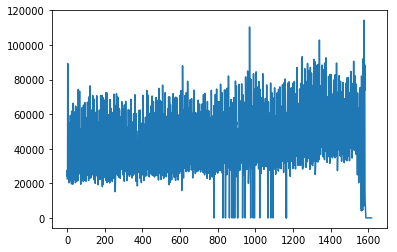

In [9]:
plt.plot(means['CashIn'].values)
plt.show()

We have outliers:
- Some values are 0.
- There are large spikes in some places.

I will begin with removing the 0s.

## 1.1 Outliers: Removing 0s

Let's see the distribution using bin graphs:

In [10]:
DRAW_BIN_WITH = 'CashIn'
N_BINS = 40

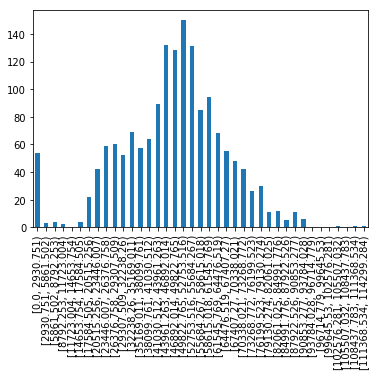

In [11]:
begin = means.describe().loc['min'][DRAW_BIN_WITH]
to = means.describe().loc['max'][DRAW_BIN_WITH]
bins = np.linspace(start = begin, stop = to + 1, num = N_BINS)

pd.cut(means[DRAW_BIN_WITH], bins, right=False).value_counts(sort=False).plot.bar()

In [12]:
(means == 0.0).value_counts()

CashIn  CashOut
False   False      1564
True    True         54
dtype: int64

54 rows have 0 in CashIn column

In [20]:
#from datetime import datetime

# input:    dataframe['CashIn', 'CashOut']
# do:       remove outliers and interpolate. inplace=True by default. Maybe add an option
def clean_data(df, freq='D', drop_zeros=True):
    # switch to datetimeIndex
    df.index = pd.to_datetime(df.index)

    # clean outliers
    # This may not be the best course of action when we are looking at a single ATM
    if drop_zeros:
        df[df['CashIn'] == 0] = np.NaN

    # upsample
    df = df.resample('D').asfreq()

    # interpolate (Maybe add better methods later)
    df = df.interpolate()

    return df

In [21]:
means = clean_data(means)

In [22]:
means.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2020-05-27', '2020-05-28', '2020-05-29', '2020-05-30',
               '2020-05-31', '2020-06-01', '2020-06-02', '2020-06-03',
               '2020-06-04', '2020-06-05'],
              dtype='datetime64[ns]', name='HistoryDate', length=1618, freq='D')

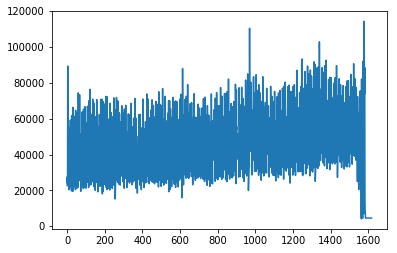

In [23]:
plt.plot(means['CashIn'].values)
plt.show()

Looking at the numbers and standard diviation after dropping null values

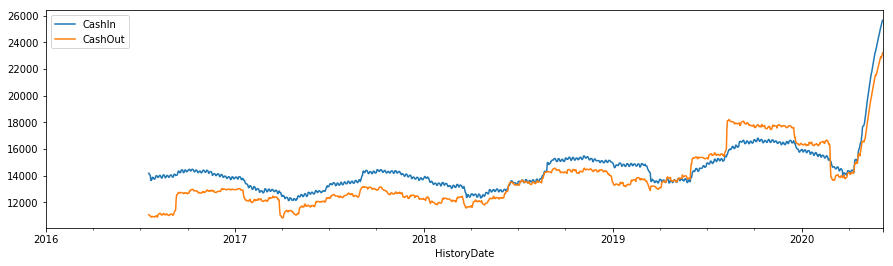

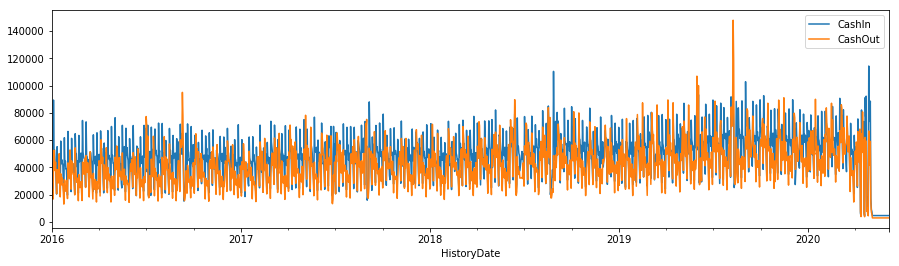

In [24]:
means.rolling(200).std().plot(figsize=(15, 4))
means.plot(figsize=(15, 4))

Here are the bins after removing the 0s (Using pandas alternative to manually creating the bins):

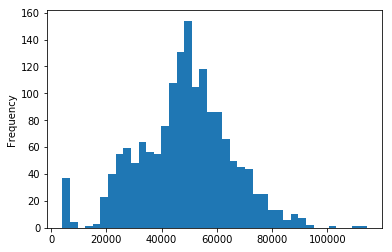

In [25]:
means[DRAW_BIN_WITH].plot.hist(bins = N_BINS)

## 1.3 Outliers: Revisited

There are some spikes in the data. Observe the CashOut spike in 2019:

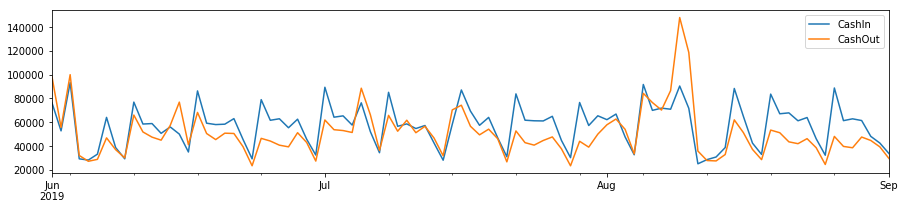

In [21]:
quarter_range = pd.date_range(start='2019-06', end='2019-09')
means.loc[quarter_range].plot(figsize = (15,3))

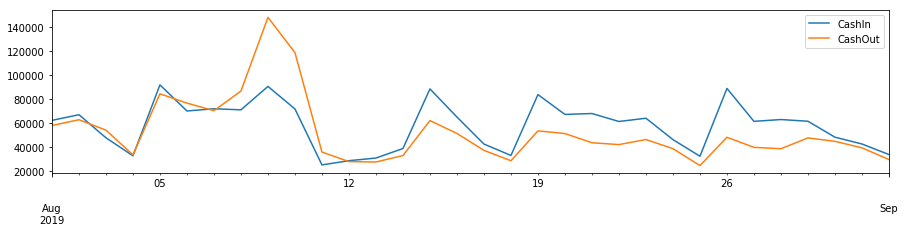

In [22]:
month_range = pd.date_range(start='2019-8', end='2019-09')
means.loc[month_range].plot(figsize = (15,3))

In [23]:
month_range = pd.date_range(start='2019-8-5', end='2019-08-12')
means.loc[month_range]

,CashIn,CashOut
2019-08-05,91676.822331,84241.242978
2019-08-06,69950.590302,76510.442727
2019-08-07,71816.066667,70209.150877
2019-08-08,70916.528752,86513.772791
2019-08-09,90392.279102,147888.927069
2019-08-10,71668.636045,118548.302945
2019-08-11,25088.373072,35773.723703
2019-08-12,28588.180224,27834.467041


Jump in outflow happens at 9th of August, 2019. See the news in the links below (There is a paywall in Bloomberg, so it's a good idea to click the second link first):
- [Investors Scramble for Liras as Turkish Swap Rates Touch 1,000%](https://www.bloomberg.com/news/articles/2019-03-27/foreign-investors-are-trapped-in-turkey-days-before-elections), March 27th
- [Turkey Central Bank Removes Chief Economist, Key Officials](https://www.bloomberg.com/news/articles/2019-08-08/turkey-central-bank-removes-chief-economist-other-officials-jz34v7c6), August 9th. Hakan Kara is removed from TCMB
- [Foreigners Flee Turkish Stocks at Fastest Pace Since March 2019](https://www.bloomberg.com/news/articles/2020-08-13/foreigners-flee-turkish-stocks-at-fastest-pace-since-march-2019), August 13th

## 1.4 Shifting and Correlation

In [24]:
means['CashIn'].shift(2)

HistoryDate
2016-01-01             NaN
2016-01-02             NaN
2016-01-03    22632.234742
2016-01-04    27636.545784
2016-01-05    23769.291480
                  ...     
2020-06-01             NaN
2020-06-02             NaN
2020-06-03             NaN
2020-06-04             NaN
2020-06-05             NaN
Name: CashIn, Length: 1618, dtype: float64

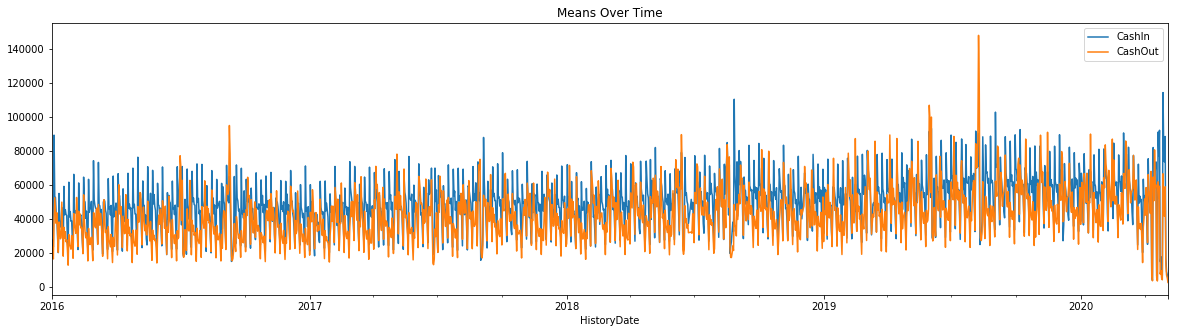

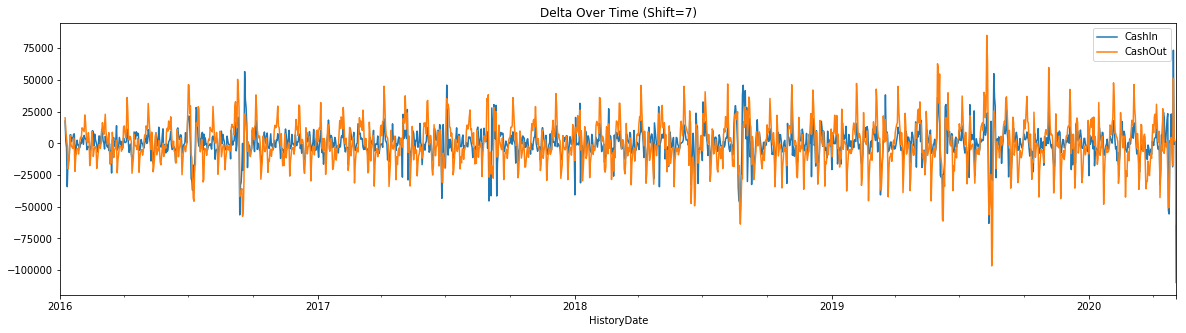

In [ ]:
DELTA_OFFSET = 7
deltas = means - means.shift(DELTA_OFFSET)
means.plot(title="Means Over Time", figsize=(20,5))
deltas.plot(title="Delta Over Time (Shift=%d)" % DELTA_OFFSET, figsize=(20,5))


In [ ]:
MAX_SHIFT = 28
shift_stds = pd.DataFrame(columns = ['CashIn_std', 'CashOut_std'])
for shift_by in range(1, MAX_SHIFT):
    deltas = means_interpolated - means_interpolated.shift(shift_by)
    shift_stds.loc[shift_by, 'CashIn_std'] = deltas['CashIn'].std()
    shift_stds.loc[shift_by, 'CashOut_std'] = deltas['CashOut'].std()
shift_stds.index = "shift_by_" + shift_stds.index.astype(str)

print()
print(shift_stds.sort_values(by = 'CashOut_std')[:5])
print()
print(shift_stds.sort_values(by = 'CashIn_std')[:5])


               CashIn_std   CashOut_std
shift_by_1   20787.412404  15539.376496
shift_by_7   11678.648383  17180.502999
shift_by_21  10959.929121  17308.736318
shift_by_3   21823.102652  18007.572092
shift_by_14  10864.028897  18224.472471

               CashIn_std   CashOut_std
shift_by_14  10864.028897  18224.472471
shift_by_21  10959.929121  17308.736318
shift_by_7   11678.648383  17180.502999
shift_by_1   20787.412404  15539.376496
shift_by_25  21093.579965  18559.797209


# 2. Focusing on Individual ATMs

In [ ]:
"Number of unique ATMs: %d" % len(df['AtmId'].unique())

'Number of unique ATMs: 1650'

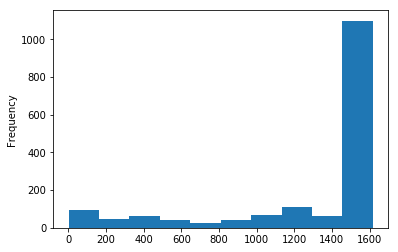

In [ ]:
df['AtmId'].value_counts().plot.hist()
plt.show()

In [ ]:
df['AtmId'].value_counts()[:10]

26637    1618
27687    1618
27663    1618
33817    1618
33821    1618
27651    1618
32785    1618
33793    1618
33795    1618
33796    1618
Name: AtmId, dtype: int64

In [ ]:
# input:    all the atm data, an atm ID
# do:       get the data of the given atm and clean it
# return:   dataframe['CashIn', 'CashOut'] for the given ATM ID
def get_atm(df, atm_id):
    
    atm_df = df[df['AtmId'] == atm_id].copy()
    atm_df.drop(columns = 'AtmId', inplace = True)
    atm_df.set_index('HistoryDate', inplace = True)
    atm_df.index = pd.to_datetime(atm_df.index)
    
    return atm_df

In [ ]:
atm_df = clean_data(get_atm(df, 26637)

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2020-05-27', '2020-05-28', '2020-05-29', '2020-05-30',
               '2020-05-31', '2020-06-01', '2020-06-02', '2020-06-03',
               '2020-06-04', '2020-06-05'],
              dtype='datetime64[ns]', name='HistoryDate', length=1618, freq=None)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA69197288>,
      dtype=object)

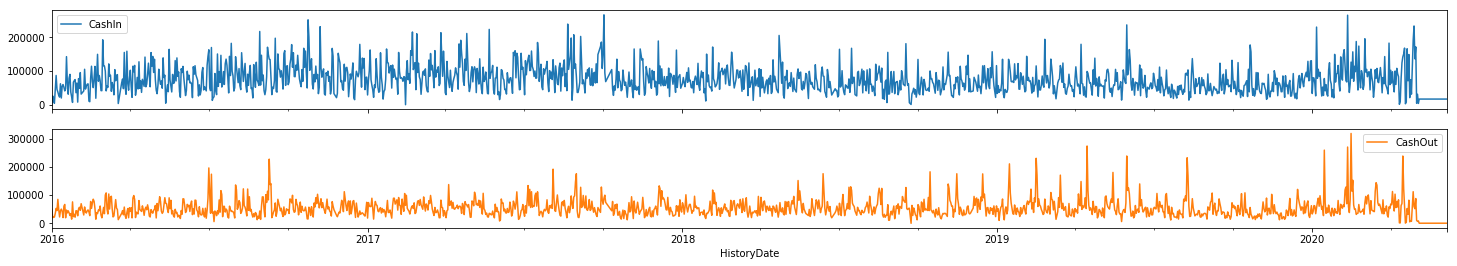

In [ ]:
atm_df[['CashIn', 'CashOut']].plot(figsize=(25,4), subplots = True)

## 2.1 Correlation Analysis

In [ ]:
atm_cashin = pd.DataFrame(atm_df['CashIn'].copy())
MAX_SHIFT = 25
for shift_by in range(1, MAX_SHIFT):
    atm_cashin['shift_' + str(shift_by)] = atm_cashin['CashIn'].shift(shift_by)
atm_cashin.dropna(inplace = True)

In [ ]:
corrs = atm_cashin.corr()

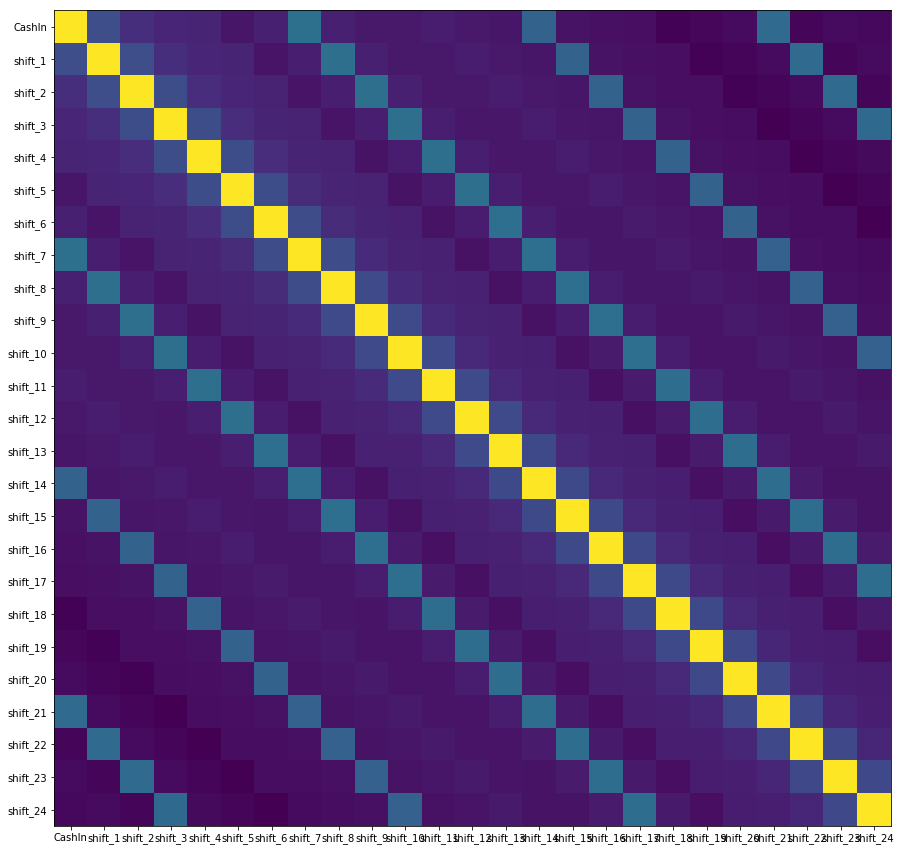

In [ ]:
# invert y axis, this way the image will resemble a proper matrix with 1s in the correct diagonal
# https://stackoverflow.com/questions/2051744/reverse-y-axis-in-pyplot
plt.figure(figsize=(15,15))
plt.gca().invert_yaxis()

plt.pcolor(corrs)
plt.yticks(np.arange(0.5, len(corrs.index), 1), corrs.index)
plt.xticks(np.arange(0.5, len(corrs.columns), 1), corrs.columns)
plt.show()

In [ ]:
clean_data(get_atm(df, 26637)

,CashIn,CashOut
HistoryDate,,
2016-01-01,1130.0,49150.0
2016-01-02,26200.0,20010.0
2016-01-03,12690.0,22190.0
2016-01-04,4450.0,21980.0
2016-01-05,48100.0,35260.0
...,...,...
2020-06-01,16920.0,350.0
2020-06-02,16920.0,350.0
2020-06-03,16920.0,350.0


## 3. Predictions with the Aggregate Demand

In [ ]:
MAX_SHIFT = 14
PREDICT_FEATURE = 'CashOut'
means_shifted = pd.DataFrame(means_interpolated[PREDICT_FEATURE].copy(), columns=[PREDICT_FEATURE])
for shift_by in range(1, MAX_SHIFT+1):
    means_shifted['shift_by_' + str(shift_by)] = means_shifted[PREDICT_FEATURE].shift(shift_by)
means_shifted.dropna(inplace=True)
means_shifted

,CashOut,shift_by_1,shift_by_2,shift_by_3,shift_by_4,shift_by_5,shift_by_6,shift_by_7,shift_by_8,shift_by_9,shift_by_10,shift_by_11,shift_by_12,shift_by_13,shift_by_14
HistoryDate,,,,,,,,,,,,,,,
2016-01-15,49997.206512,29305.484147,28441.979434,32799.991431,38354.708405,20521.749571,33242.343348,43740.910653,37534.725086,45121.282272,52577.523727,39836.343993,16629.013453,23876.908432,23631.737089
2016-01-16,33120.916881,49997.206512,29305.484147,28441.979434,32799.991431,38354.708405,20521.749571,33242.343348,43740.910653,37534.725086,45121.282272,52577.523727,39836.343993,16629.013453,23876.908432
2016-01-17,18269.168809,33120.916881,49997.206512,29305.484147,28441.979434,32799.991431,38354.708405,20521.749571,33242.343348,43740.910653,37534.725086,45121.282272,52577.523727,39836.343993,16629.013453
2016-01-18,35241.131105,18269.168809,33120.916881,49997.206512,29305.484147,28441.979434,32799.991431,38354.708405,20521.749571,33242.343348,43740.910653,37534.725086,45121.282272,52577.523727,39836.343993
2016-01-19,28751.970865,35241.131105,18269.168809,33120.916881,49997.206512,29305.484147,28441.979434,32799.991431,38354.708405,20521.749571,33242.343348,43740.910653,37534.725086,45121.282272,52577.523727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-30,59007.215190,41672.254902,44727.494752,66618.791055,4382.606569,5443.039832,9775.904962,7763.004892,59295.893855,52440.935754,61922.145353,3690.817610,5705.897973,60138.385744,58536.675978
2020-05-01,14122.028777,59007.215190,41672.254902,44727.494752,66618.791055,4382.606569,5443.039832,9775.904962,7763.004892,59295.893855,52440.935754,61922.145353,3690.817610,5705.897973,60138.385744
2020-05-02,7209.123328,14122.028777,59007.215190,41672.254902,44727.494752,66618.791055,4382.606569,5443.039832,9775.904962,7763.004892,59295.893855,52440.935754,61922.145353,3690.817610,5705.897973


In [ ]:
def loss(y_predicted, y_actual):
    return ((y_predicted - y_actual) ** 2).mean()

In [ ]:
shift_losses = pd.DataFrame(dtype='float64', columns = ["Losses"])
for i, column in enumerate(means_shifted.columns[1:]):
    l = loss(means_shifted[PREDICT_FEATURE], means_shifted[column])
    shift_losses.loc[column, "Losses"] = l
shift_losses.sort_values(by = "Losses")

,Losses
shift_by_1,2.423323e+08
shift_by_7,2.955050e+08
shift_by_3,3.246914e+08
shift_by_14,3.319230e+08
shift_by_2,3.412174e+08
shift_by_4,3.486307e+08
shift_by_10,3.955361e+08
shift_by_5,3.962516e+08
shift_by_6,4.077076e+08
shift_by_11,4.250098e+08


These loss values are our base scores. We will compare these with the scores we get from models.

In [ ]:
X = means_shifted.drop(columns=PREDICT_FEATURE)
y = means_shifted[PREDICT_FEATURE]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

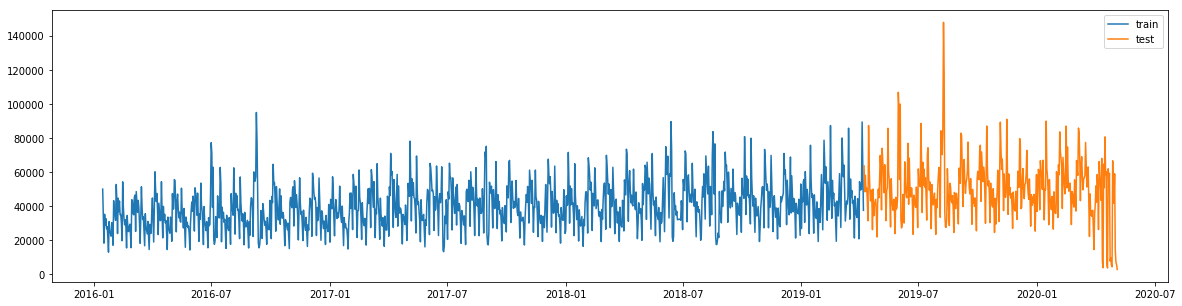

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(y_train, label="train")
plt.plot(y_test, label="test")
plt.legend()
plt.show()